# Example: Static equilibrium calculations

## Inverse and forward Grad-Shafranov solvers
This example notebook shows how to use FreeGSNKE to solve static Grad-Shafranov (GS) problems. Examples are provided for both inverse and forward solve modes. 

By inverse solve mode, we refer to the case in which we seek a set of coil currents such that a user-specified magnetic configuration (i.e. some constraints on the plasma) is satisfied.

By forward solve mode, we refer to the case in which the coil currents and profile parameterisation are chosen by the user and the Grad-Shafranov equation is solved for the equilibrium. 

Below, we illustrate how to use the solvers for both diverted and limited plasma configurations in the MAST-U tokamak. 

## Import packages

In [1]:
import os
import matplotlib.pyplot as plt

## Create the machine object

First, we build the MAST-U machine object. This can be done using the default pickle files as saved in the "machine_configs" directory or you can build using the geometry data from a particular shot number by uncommenting the 'get_machine_data' function below (note, this will overwrite the existing pickle files). 

FreeGSNKE requires the following envirnoment variables in order to build the machine: ACTIVE_COILS_PATH, PASSIVE_COILS_PATH, WALL_PATH, LIMITER_PATH, PROBE_PATH. 

Note 1: There are two options used for building the active coils in FreeGSNKE. The first sets up **symmetric** coils where the corresponding up/down coils in MAST-U (e.g. P4_upper and P4_lower) are wired **in series** and therefore will be assigned the same current value later. The second option sets up **non-symmetric** coils in which the up/down coils are modelled independently and can be assigned **different** currents (i.e. they are **not wired in series**). Set the 'symmetric_machine' parameter to either 'True' or 'False' to toggle this setting. We use the **non-symmetric** setting here as the coil currents in EFIT++ are calculated independently (though you may test out the symmetric case too to see the differences). 

Note 2: The magnetic probes are not used in this script (see "example1c" for how to use them). 

In [2]:
# set paths (choose symmetric or non-symmetric active coils)
symmetric_machine = True
if symmetric_machine:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils.pickle"
else:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils_nonsym.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_limiter.pickle"
os.environ["PROBE_PATH"] = f"../machine_configs/MAST-U/MAST-U_magnetic_probes.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

## Instantiate an equilibrium

We are now ready to build a plasma equilibrium in the tokamak object. This is done using the `freegsfast.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is recommended to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters.

A tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial plasma flux function can be provided to the `psi` parameter (commented out in the following code).

In [4]:
from freegsnke import equilibrium_update

# note that both nx and ny have 
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

## Instantiate a profile object

A profile object can now be instantiated. This sets the parameterisation and properties of the profile function, as well as the value of the total plasma current.

The profiles used in this notebook follow the notation of Jeon (2015) for the toroidal plasma current:
$$j_{pl}=\lambda \left( 1-\psi_{n}^{\alpha_m} \right)^{\alpha_n}\left( \beta_{0}R/R_{0}+(1-\beta_{0}) R_{0}/R \right) $$ 
The first contribution is the pressure support $p'$, the second one is the toroidal-field support $f'f$.

FreeGSNKE accepts the same profile classes available in FreeGSFast: `ConstrainPaxisIp`, `ConstrainBetapIp`, or `Lao85` (used in a future notebook). 

In the first case, the user defines the value of the plasma pressure at the magnetic axis, $p_a$. In the second case, the value of $\beta_p$, a proxy of the poloidal beta of the plasma is set.

The following example uses the `ConstrainPaxisIp` function, and an example demonstrating use of the `ConstrainBetapIp` function is in the following text cell.

Equilibrium (`eq`) and limiter (`tokamak.limiter`) objects are passed to the profile to inform calculations relating to the limiter.

The following parameters set the value for the profile properties.
- `paxis`: plasma pressure on axis [Pascals].
- `Ip`: total plasma current [Amps].
- `fvac`: vacuum toroidal field strength f = R * Bt.

The `alpha_m` and `alpha_n` coefficients define the 'peakedness' of the plasma current density distribution. See [this paper](https://arxiv.org/abs/1503.03135) for example. A particular "Lao" profile can be constructed using `alpha_m=1` and `alpha_n=2`.

In [5]:
from freegsnke.jtor_update import ConstrainPaxisIp

profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

As promised, here is an example of using `ConstrainBetapIp` instead. The call signature is nearly identical, except the poloidal beta (`betap`) is used instead. 'betap' is a pure number.

```python
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,
    limiter=tokamak.limiter,
    betap=0.05,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)
```

## Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of the computational domain and of the tokamak properties.
The solver below can be used for both inverse and forward solve modes, as exemplified below.

Note: It's not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid and tokamak are identical. 

In [6]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

## First solve: Inverse

We start with an _inverse_ solve in which we use a `constrain` object to set the user-specified magnetic constraints.

FreeGSNKE uses FreeGSFast's `constrain` object, which accepts both constraints on the location of the X-points (`xpoints`) and constraints on the geometry of the last closed closed flux surface (`isoflux`).

During an inverse solve, the desired magnetic configuration described by the constrain object is used to seek a suitable set of coil currents that satisfy the chosen configuration. Both the coil currents and the total flux $\psi(R,Z)$ are _outputs_ (among other quantities of interest).

Here, we specify a few constraints on the X-point position(s) and on some _isoflux_ points where $\psi(R,Z)$ should be the same.

In [7]:
import freegsfast

# Set X-point coordinates
Rx = 0.6
Zx = 1.1
xpoints = [(Rx, -Zx),   
           (Rx,  Zx)]

# Set any desired isoflux constraints,
# these have structure (R1, Z1, R2, Z2)
# where (R1, Z1) and (R2, Z2) are 
# desired to be on the same flux contour.
Rmid = 1.4   # Outboard midplane
Rin = 0.35    # Inboard midplane
isoflux = [(Rx,Zx, Rx,-Zx), # link X-points
           (Rmid, 0, Rin, 0.0), # link inner and outer midplane points
           (Rmid, 0, Rx, Zx), # link outer midplane point and X-point

        #   some additional constraints
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),
           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]
           
# Instantiate the constrain object
constrain = freegsfast.control.constrain(xpoints=xpoints, 
                                     isoflux=isoflux,
                                     gamma=5e-7
                                    )

Since inverse problems are often underconstrained, we also specify the quadratic regularization parameter `gamma` (Tikhonov regularization in the quadratic least squares problem). Higher values of `gamma` encourage lower absolute coil current values. It is sometimes useful to experiment with different values of `gamma` to explore whether the converged solution departs from the desired constraints. 

It is also possible to fix specific coil current values for individual coils as part of the inverse solve and toggle them on or off. This means that the inverse solve procedure will not be allowed to vary those current values (if 'control' is set to 'False').

Note: passive coils are automatically toggled off during an inverse solve.

Coil current values set as part of the equilibrium can be accessed using
```python 
eq.tokamak['coil_name'].current
```
For example, 
```python 
eq.tokamak['P6'].current
```
should return the current in coil 'P6' (which is zero at the moment as no currents have been assigned to the 'eq.tokamak' object since it was initialised).

As an example, we will fix the `Solenoid` current to 5000 Amps and seek a solution in which this value is fixed, rather than optimised by the inverse solve.

In [8]:
eq.tokamak['Solenoid'].current = 5000
eq.tokamak['Solenoid'].control = False  # ensures the current in the Solenoid is fixed

The following is the 'solve' call itself. Since a constrain object is provided, this is interpreted as an _inverse_ call and executed as such. The 'target_relative_tolerance' is the maximum relative error on the plasma flux function allowed for convergence. 

In [9]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

The following shows how to display the resulting equilibrium, together with the imposed constraints.

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

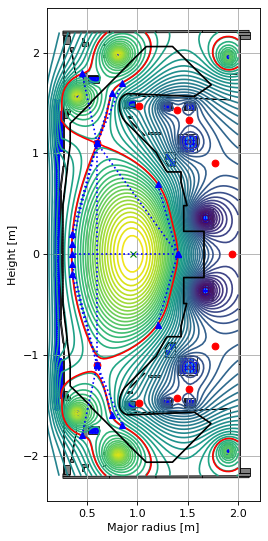

In [11]:
fig = plt.figure(figsize=(4, 8), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
constrain.plot(axis=ax,show=False)

A solve call will modify the equilibrium object in place. That means that certain quantities within the object will be updated as a result of the solve. 

Various differeny quantities and functions can be access via the 'eq' and 'profile' objects. For example:
- the total flux can be accessed with `eq.psi()`.
- the plasma flux with `eq.plasma_psi`.
- the active coil + passive structure flux with `eq.tokamak.psi(eq.R, eq.Z)`.

Explore `eq.` to see more (also `profiles.`, e.g. the plasma current distribution over the domain can be found at `profiles.jtor`).

The set of optimised coil currents can be retrieved using `eq.tokamak.getCurrents()` havin gbeen assigned to the equilibrium object.

The following will save them for later use. 

In [18]:
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

### 2. Forward solve

As described before, in a forward solve we use some fixed coil current values as inputs, and solve for the corresponding equilibrium. 

As an example, we can use the set of currents identified in the inverse solve above.
Below we instantiate a new equilibrium and assign such current values to its tokamak.

In [ ]:
eq_forward = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

for key in inverse_current_values.keys():
    eq_forward.tokamak[key].current = inverse_current_values[key]

The syntax of a _forward_ solve is identical to that of an inverse call: `GSStaticSolver.solve()`. However, the nonlinear solver is __NOT__ provided with a `constrain` object: `constrain=None` is used as an input. Therefore, coil current values are not changed and the solver uses them as inputs to calculate the appropriate flux function.

The forward nonlinear static solver in FreeGSNKE uses a Newton-Krylov implementation, which allows considerably more restrictive tolerance requests when compared to inverse solves. 

In [ ]:
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

In practice, with the above, we have improved on the equilibrium created in the inverse solve. Both coil currents and plasma profile properties have been kept the same, but the tolerance has improved substantially.

Since it is often difficult to achieve low relative tolerances in _inverse_ solve calls (for example, the above was set at a loose target_relative_tolerance=1e-3), the above strategy of using a forward solve after an inverse one is useful to obtain better equilibria.

We remark that the second forward call uses the coil current values obtained by the inverse solve above as inputs, to output a better flux function. 
In the forward call coil currents are not modified. 

As an additional example, below we manually vary some of the coil currents, perform new forward solves and compare the resulting equilibria.
Note that the manual current changes cause one of the equilibria to transition from a diverted to a limiter configuration (This is handled through FreeGSfast).

In [ ]:
from copy import deepcopy
eq_forward_1 = deepcopy(eq)
eq_forward_2 = deepcopy(eq)

eq_forward_1.tokamak['P4'].current *= 1.5
GSStaticSolver.solve(eq=eq_forward_1, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

eq_forward_2.tokamak['P4'].current *= 1.5**2
GSStaticSolver.solve(eq=eq_forward_2, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(131)
ax.grid(True,which='both')
eq_forward.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
ax = fig.add_subplot(132)
ax.grid(True,which='both')
eq_forward_1.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
ax = fig.add_subplot(133)
ax.grid(True,which='both')
eq_forward_2.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)


Finally we illustrate use the profile object `ConstrainBetapIp`. All previous examples have used the same profile object `ConstrainPaxisIp`.
First we instantiate the new profile object.

In [ ]:
from freegsnke.jtor_update import ConstrainBetapIp
profiles_beta = ConstrainBetapIp(
    eq=eq,
    limiter=tokamak.limiter,
    betap=0.05,
    Ip=6e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

Then we can use it in a solve call. 

In [ ]:
eq_beta = deepcopy(eq_forward)

GSStaticSolver.solve(eq=eq_beta, 
                     profiles=profiles_beta, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# This plots the resulting equilibrium
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq_beta.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)


## 3. Limited Equilibrium
We repeat parts of the example above for a plasma in a limited configuration. This requires use of FreeGSfast, please make sure that is correctly installed. 
In a limiter configuration the plasma "touches" the limiter of the tokamak and is confined by the solid structures of the vessel. The LCFS is the closed contour that is furthest from the magnetic axis that just barely touches (it is tangent to) the limiter.

Below we illustrate an inverse solve seeking coil current values for a limiter configuration. That is followed by a forward solve to improve the tolerance. 
Rather than instantiating a new equilibrium we use one of the above. We also use the same profile object, but illustrate how to vary the total plasma current and pressure on axis.

In [ ]:
# Sets some magnetic constraints
Rx = 0.45
Zx = 1.18

Rmid = 1.4   # Outboard midplane
Rin = 0.24  # Inboard midplane

xpoints = [(Rx, -Zx),   # (R,Z) locations of X-points
           (Rx,  Zx)]

isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),

           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),
           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]

# let's seek an up-down symmetric equilibrium 
# by imposing the current in P6 is zero
# eq.tokamak['P6'].current = 0
# eq.tokamak['P6'].control = False
# let's assume we're also seeking an equilibrium 
# with no Solenoid current
eq.tokamak['Solenoid'].current = 0
eq.tokamak['Solenoid'].control = False

# We pass the magnetic constraints to a new constrain object
constrain = freegsfast.control.constrain(xpoints=xpoints, 
                                     isoflux=isoflux,
                                     gamma=5e-6, 
                                    )

# We modify the total plasma current
profiles.Ip = 4e5
# We modify the pressure on the magnetic axis
profiles.paxis = 6e3

# This is the inverse solve, which seeks and assigns the coil currents
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

# This is the forward solve that uses the currents above to get better convergence
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# This plots the resulting equilibrium
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
constrain.plot(axis=ax,show=False)


Now, let's assume we wish to set the solenoid current to 40000 Amperes. It is advisable to do so in stages as this is easier for the inverse solver to handle while avoiding non-recoverable configurations. 

In [ ]:
# We first raise the Solenoid current to some intermediate value
# Note that `eq.tokamak['Solenoid'].control = False` from above
eq.tokamak['Solenoid'].current = 15000
# We proceed to a first inverse solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

# We raise the Solenoid current to the desired value
eq.tokamak['Solenoid'].current = 40000
# We proceed to the final inverse solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

# This is the forward solve that uses the currents above to get better convergence
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# This plots the resulting equilibrium
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
constrain.plot(axis=ax,show=False)

### 4. Forward-solve from scratch, using saved currents.
The example below does not assume the above has been executed, and can be run standalone in a new kernel.
Make sure, however, that the dictionary of currents has been correctly created using the example above itself.

In [ ]:
import matplotlib.pyplot as plt

import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"

# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# This plots the resulting equilibrium
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)